# Darshan-LDMS Integrator

A framework that integrates Darshan and LDMS to provide low-latency monitoring of I/O event data during runtime. 

**[Darshan](https://www.mcs.anl.gov/research/projects/darshan/)**: a lightweight I/O characterization tool that transparently captures application I/O behavior from HPC applications with minimal overhead.

**[Lightweight Distributed Metric Service (LDMS)](https://ovis-hpc.readthedocs.io/en/latest/ldms/ldms-quickstart.html)**: a low-overhead production monitoring system that can run on 
HPC machines. Capability to collect, transport, aggregate and store timeseries data during runtime.

![Darshan-LDMS Integration](Darshan-LDMSIntegration.png)

### Main benefits

- Storage in CSV format: easier to be processed by most data analysis tools
- Absolute time-series data with higher granularity: can be used to detect I/O-related runtime bottlenecks, captures more details about the execution
- Captures read/write/close/open/flushes
- Captures POSIX, MPI-IO and STDIO
- Captures and distincts between STDIN/STDOUT/STDERR for POSIX opens

### Local installation

- LDMS-Darshan Integration is available on Darshan's main branch: https://github.com/darshan-hpc/darshan/blob/main/darshan-runtime/lib/darshan-ldms.c
- Instructions to install LDMS streams and Darshan-LDMS Integration here: https://ovis-hpc.readthedocs.io/en/latest/ldms/ldms-streams.html#darshan

### Installation in the cloud AWS

- Notebook Tutorial [here](./aws_configuring.ipynb)
- Video tutorial - one node [here](https://drive.google.com/file/d/1xFmOxJpRhOOWyEAMkv6fxEGIFoTA4_YZ/view?usp=sharing)
- Video tutorial - multinode [here](https://drive.google.com/file/d/1kucLEIjtf3sB74HQ26iXd71TRH37eAOQ/view?usp=sharing)

### Example file collected by the LDMS-Darshan Integrator

In [2]:
!head -n5 ./../ior/eclipse/darshan-ldms-output/csv/8m-4m/test_all_jobs.csv

uid,exe,job_id,rank,ProducerName,file,record_id,module,type,max_byte,switches,flushes,cnt,op,pt_sel,irreg_hslab,reg_hslab,ndims,npoints,off,len,start,dur,total,timestamp
12345,/projects/ovis/darshanConnector/apps/rhel9.7/ior/build/bin/ior,17901504,0,n19,<STDIN>,92233720368547758,STDIO,MET,-1,-1,-1,1,open,-1,-1,-1,-1,-1,-1,-1,0.000000,0.000000,0.000000,1702064106.980885
12345,/projects/ovis/darshanConnector/apps/rhel9.7/ior/build/bin/ior,17901504,0,n19,<STDOUT>,92233720368547758,STDIO,MET,-1,-1,-1,1,open,-1,-1,-1,-1,-1,-1,-1,0.000000,0.000000,0.000000,1702064106.980885
12345,/projects/ovis/darshanConnector/apps/rhel9.7/ior/build/bin/ior,17901504,0,n19,<STDERR>,72382572414791935,STDIO,MET,-1,-1,-1,1,open,-1,-1,-1,-1,-1,-1,-1,0.000000,0.000000,0.000000,1702064106.980885
12345,N/A,17901504,0,n19,N/A,92233720368547758,STDIO,MOD,51,-1,0,1,write,-1,-1,-1,-1,-1,0,52,0.024641,0.000008,0.000008,1702064107.005534



## Performance analysis and diagnosis of parallel I/O applications

Our goal is to close the gap between tracing and diagnosing of I/O applications using LDMS-Darshan integration logs. Darshan-LDMS is a framework that integrates Darshan and LDMS to provide low-latency monitoring of I/O event data during runtime. Absolute timestamps can be used to diagnose these bottlenecks by correlating the I/O logs with other system monitoring logs - deeper dive into the source of the problem.

![static analysis post collecting data](static_analysis.png)

#### Input data

LDMS-Darshan Integration CSV file. We have examples for experiments with the HPC [IOR benchmark](https://github.com/hpc/ior) in [this directory](https://github.com/anaveroneze/ldms-darshan-analysis/tree/main/ior/eclipse/darshan-ldms-output/csv/8m-4m). Each file constains information about a single job executions, but the analysis code can analyse and provide results about distinct jobs in the same file.

#### Output

- Jobs summary file
- Load imbalance evaluation
- Visualizations

#### Progress Rate Imbalance Metrics

To measure the execution time distribution among the ranks utilized.

**[Average](https://www.researchgate.net/publication/301700628_Using_SimGrid_to_Evaluate_the_Impact_of_AMPI_Load_Balancing_In_a_Geophysics_HPC_Application?channel=doi&linkId=5723a6f208ae262228aa71a4&showFulltext=true)**: measures the average time spent computing.

$$
\text{AVG} = \frac{\text{Total application runtime}}{\text{Number of ranks}}
$$

**[Imbalance time](https://link.springer.com/chapter/10.1007/978-3-540-74466-5_17)**: Measures the execution time that would be gained if all ranks execute for the same time.

$$
\text{IT} = \text{Maximum Load} - \text{AVG}
$$

**[Percent Imbalance](https://dl.acm.org/doi/10.1145/2304576.2304601)**: Measures the performance % that could be gained with an ideal load distribution.

$$
\text{PI} = \left( \frac{\text{Maximum Load}}{\text{AVG}} - 1 \right) \times 100
$$


**[Imbalance Percentage](https://link.springer.com/chapter/10.1007/978-3-540-74466-5_17)**: Measures how bad is the imbalance in a range of 0 to 100, where a perfectly balanced code would have 0 imbalance percentage. If the IP is lower than the PI it suggests that the load imbalance is more influenced by the number of ranks than by the difference between the maximum and average loads.

$$
\text{IP} = \left( \frac{\text{Maximum Load} - \text{AVG}}{\text{Maximum Load}} \right) \times \left( \frac{\text{Number of ranks}}{\text{Number of ranks} - 1} \right)
$$

## Define **input** filename and **output** filepath

In [65]:
INPUTFILE="./../ior/eclipse/darshan-ldms-output/csv/8m-4m/17901517-IOR_pscratch_1024_none.csv"
FILEPATH="./../ior/eclipse/darshan-ldms-output/csv/8m-4m/"

## Code for capturing statistics about the execution:

In [66]:
import os, csv, time, glob, argparse, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from math import sqrt 
import rpy2.robjects as ro
import seaborn as sns
from datetime import datetime

class Job:

    def __init__(self, job, ranks, nodes, users, filename, exe):
        
        self.job = job
        self.ranks = ranks
        self.nodes = nodes
        self.users = users
        self.filename = filename
        self.exe = exe

def app_phase(df, output_file, self):
    write_to_file("---------------------------------------")
    write_to_file("EXECUTION SUMMARY PER APPLICATION PHASE:")
    write_to_file("---------------------------------------")

# Calculate and write general statistics in a file
def get_statistics(df, output_file, self):

    with open(output_file, 'w') as f:

        def write_to_file(*args):
            print(" ".join(map(str, args)), file=f, flush=True)

        write_to_file("---------------------------------------")
        write_to_file("JOB CHARACTERISTICS:")
        write_to_file("---------------------------------------")
        write_to_file("Job ID:", self.job)
        write_to_file(len(self.ranks), "Rank (s):", sorted(self.ranks))
        write_to_file(len(self.nodes), "Node (s):", sorted(self.nodes))
        write_to_file("User ID:", self.users)
        write_to_file("Directory:", self.exe)
        write_to_file("Modules collected:", df['module'].unique())
        write_to_file("Module data (MOD):", list(df.type).count('MOD'))
        write_to_file("Meta data (MET):", list(df.type).count('MET'))
        exec_time = round(df['end'].max() - df['start'].min(), 5)
        write_to_file("I/O runtime:", exec_time, "seconds")
        write_to_file("Bandwidth (MiB/second):", round((df['len'].sum() / exec_time) / (1024 ** 2), 2))

        df_read = df[df['op'] == "read"]
        df_write = df[df['op'] == "write"]

        write_to_file("---------------------------------------")
        write_to_file("I/O OPERATIONS:")
        write_to_file("---------------------------------------")

        current_op = None
        phase_start = None
        total_durations = {'read': 0, 'write': 0, 'open': 0, 'close': 0}

        def update_total_duration(op, phase_start, phase_end, length):
            if current_op is not None and current_op == op:
                total_durations[op] += (phase_end - phase_start)

        for index, row in df.iterrows():
            if current_op is None or current_op != row['op']:
                update_total_duration(current_op, phase_start, row['end'], row['len'])
                current_op = row['op']
                phase_start = row['start']

        # Get the last phase
        update_total_duration(current_op, phase_start, row['end'], row['len'])

        pivot_df = df.pivot_table(index=None, columns='op', values='len', aggfunc='sum')
        for op, duration in total_durations.items():
            write_to_file(f'Duration {op}s: {round(duration, 4)} seconds')

        write_to_file("\nREADS:", round(df_read['len'].sum() / (1024 ** 2)),  "(MiB)")
        write_to_file("Max size per rank:", round(df_read.groupby('rank')['len'].agg('sum').max() / (1024 ** 2)), "MiB")
        write_to_file("Min size per rank:", round(df_read.groupby('rank')['len'].agg('sum').min() / (1024 ** 2)), "MiB")
        write_to_file("Bandwidth (MiB/second):", round((df_read['len'].sum() / (df_read['end'].max() - df_read['start'].min())) / (1024 ** 2), 2))
        
        write_to_file("\nWRITES:", round(df_write['len'].sum() / (1024 ** 2)), "(MiB)")
        write_to_file("Max size per rank:", round(df_write.groupby('rank')['len'].agg('sum').max() / (1024 ** 2)), "MiB")
        write_to_file("Min size per rank:", round(df_write.groupby('rank')['len'].agg('sum').min() / (1024 ** 2)), "MiB")
        write_to_file("Bandwidth (MiB/second):", round((df_write['len'].sum() / (df_write['end'].max() - df_write['start'].min())) / (1024 ** 2),2))

        # IMBALANCE METRICS:
        write_to_file("---------------------------------------")
        write_to_file("PROGRESS RATE IMBALANCE:")
        write_to_file("---------------------------------------")
        # Get difference between execution time and time processing I/O per rank
        df_idle = df.groupby('rank')['dur'].sum().reset_index()
        df_idle.columns = ['Rank ID', 'Rank I/O Time']
        df_idle['Rank I/O Time'] = round(df_idle['Rank I/O Time'], 2)
        df_idle['Total I/O Time - Rank I/O Time'] = round(exec_time - df_idle['Rank I/O Time'], 2)
        df_idle = df_idle.sort_values(by='Rank I/O Time', ascending=False)

        write_to_file("Total execution time:", exec_time, "seconds")
        num_ranks = df_idle['Rank I/O Time'].nunique()
        average = df_idle['Rank I/O Time'].sum() / num_ranks
        write_to_file("- Average:", round(average), "seconds")
        it = df_idle['Rank I/O Time'].max() - average
        write_to_file("- Imbalance Time:", round(it, 2), "seconds")
        pi = ((df_idle['Rank I/O Time'].max() / average) - 1) * 100
        write_to_file("- Percent Imbalance:", round(pi, 2), "%")
        ip = (it / df_idle['Rank I/O Time'].max()) * (num_ranks / (num_ranks - 1))
        write_to_file("- Imbalance Percentage:", round(ip, 2), "%")
        std = np.std(df_idle['Rank I/O Time'])
        write_to_file("- Standard deviation", round(std, 2), "seconds")

        write_to_file("---------------------------------------")
        write_to_file("SUMMARY PER RANK: \n(ordered by higher I/O time)")
        write_to_file("---------------------------------------")
        df.loc[:, 'start'] = pd.to_datetime(df['start'], unit='s').dt.round('S')
        df.loc[:, 'end'] = pd.to_datetime(df['end'], unit='s').dt.round('S')
        # write_to_file(df_idle)
        write_to_file(df_idle.to_string(index=False))

## Run to get jobs report:

In [67]:
# Read CSV file, define jobs characteristics and calculate load metrics
def main(filename, filepath): 

    df = pd.read_csv(filename, engine="pyarrow")

    # Get basic info about each Job:
    local_df = pd.DataFrame()
    for i in df.job_id.unique():
        
        local_df = df[df['job_id'] == i].copy()
        job = Job(i, local_df['rank'].unique(), local_df['ProducerName'].unique(),local_df['uid'].unique(), 
            local_df['file'].unique(), local_df['exe'].unique())

        local_df.loc[:, 'start'] = local_df['timestamp'] - local_df['dur']
        local_df.loc[:, 'end'] = local_df['timestamp']
        
        # Job characteristics and statistics:  
        output_file = filename.replace(".csv", ".txt")
        get_statistics(local_df, output_file, job)

if __name__ == '__main__':

    start_time_exec = time.time()
    main(INPUTFILE, FILEPATH)   
    end_time_exec = time.time()
    print("Execution time:", end_time_exec - start_time_exec, "seconds")

Execution time: 7.028652191162109 seconds


## Checking output file:

In [68]:
!cat ./../ior/eclipse/darshan-ldms-output/csv/8m-4m/17901517-IOR_pscratch_1024_none.txt

---------------------------------------
JOB CHARACTERISTICS:
---------------------------------------
Job ID: 17901517
36 Rank (s): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
1 Node (s): ['n19']
User ID: [12345]
Directory: ['/projects/ovis/darshanConnector/apps/rhel9.7/ior/build/bin/ior' 'N/A']
Modules collected: ['STDIO' 'POSIX']
Module data (MOD): 147672
Meta data (MET): 75
I/O runtime: 99.25431 seconds
Bandwidth (MiB/second): 5942.55
---------------------------------------
I/O OPERATIONS:
---------------------------------------
Duration reads: 67.6207 seconds
Duration writes: 32.9481 seconds
Duration opens: 0.5302 seconds
Duration closes: 0.2308 seconds

READS: 294912 (MiB)
Max size per rank: 8192 MiB
Min size per rank: 8192 MiB
Bandwidth (MiB/second): 4418.12

WRITES: 294912 (MiB)
Max size per rank: 8192 MiB
Min size per rank: 8192 MiB
Bandwidth (MiB/second): 2971.83
-------------------------

## Code for visualizations in Python:

In [192]:
# SPATIAL AND TEMPORAL VISUALIZATIONS

def plot_average_duration(df, filepath, job_id):

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df['start'] = df['timestamp'] - pd.to_timedelta(df['dur'], unit='s')
    df['duration'] = (df['timestamp'] - df['start']).dt.total_seconds()
    df_write = df[df['op'] == "write"].copy()
    df_read = df[df['op'] == "read"].copy()

    grouped_write = df_write.groupby(pd.Grouper(key='timestamp', freq='1s'))['duration'].mean()
    grouped_read = df_read.groupby(pd.Grouper(key='timestamp', freq='1s'))['duration'].mean()

    plt.clf()
    plt.figure(figsize=(8, 2))

    plt.plot(grouped_write.index, grouped_write.values, label='write', color='blue')
    plt.plot(grouped_read.index, grouped_read.values, label='read', color='orange')

    plt.xlim(df['timestamp'].min(), df['timestamp'].max())
    plt.ylim(0, max(grouped_write.max(), grouped_read.max()))
    plt.xlabel('Timestamp')
    plt.ylabel('Average Duration (secs)')
    plt.legend(title='Operation', loc='upper right', bbox_to_anchor=(1.0, 1.0))
    plt.show()
    plt.clf()
    plt.close()

    return

# Bandwidth per rank and operation 
def plot_bandwidth_per_rank(df, filepath, job_id):

    df = df[df['op'].isin(['write', 'read'])]
    df['bw'] = np.where(df['dur'] != 0, df['len'] / (df['dur'] * 2**20), 0)

    df_bw = df.groupby(['rank', 'op'])['bw'].mean().unstack()
    colors = {'write': 'blue', 'read': 'orange'}
    
    fig, ax = plt.subplots(figsize=(6, 3))
    df_bw = df_bw.loc[:, ::-1]
    df_bw.plot(kind='barh', stacked=True, color=[colors[op] for op in df_bw.columns], ax=ax, width=0.8)

    ax.set_xlabel('Bandwidth (MiB/second)')
    ax.set_ylabel('Rank')
    ax.set_yticks(range(0, 37, 4))
    ax.legend(title='Operation', loc='upper right', bbox_to_anchor=(1.0, 1.0))
    plt.show()
    plt.clf()
    plt.close()

    return

def plot_temporal(df, filepath, job_id):

    # df = df.head(5000)
    df['start'] = pd.to_datetime(df['timestamp'], unit='s') - pd.to_timedelta(df['dur'], unit='s')
    df[['start', 'timestamp']] = df[['start', 'timestamp']].apply(pd.to_datetime)
    df['dur'] = pd.to_timedelta(df['dur'], unit='s')

    colors = {'write': 'blue', 'open': 'green', 'close': 'red', 'read': 'orange'} 
    df['color'] = df['op'].map(colors)
    fig, ax = plt.subplots(figsize=(15, 3))

    ax.barh(y=df['rank'], width=df['dur'], left=df['start'], color=df['color'])
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Rank')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.set_yticks(range(0, 37, 4))

    legend_labels = [plt.Line2D([0], [0], color=color, linewidth=3, linestyle='-') for op, color in colors.items()]
    ax.legend(legend_labels, colors.keys(), loc='upper right')
    ax.set_ylim(df['rank'].min() - 1, df['rank'].max() + 1)

    plt.show()
    plt.clf()
    plt.close()

    return


## Run to get visualizations:

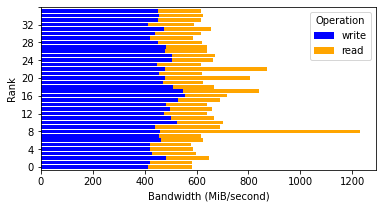

<Figure size 432x288 with 0 Axes>

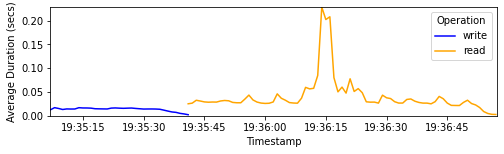

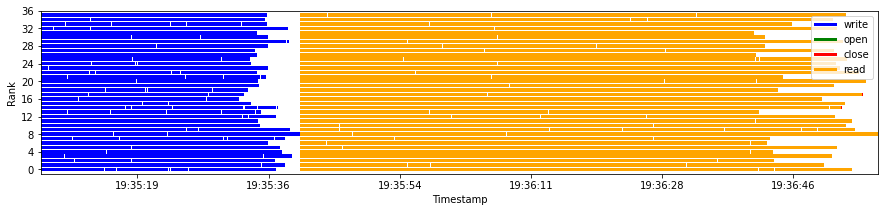

Execution time: 151.6257872581482 seconds


In [193]:
import warnings 
warnings.filterwarnings('ignore') 

# Read file and get visualizations
def main(filename, filepath): 

    df = pd.read_csv(filename, engine="pyarrow")

    # Get basic info about each Job:
    local_df = pd.DataFrame()
    for i in df.job_id.unique():
        
        local_df = df[df['job_id'] == i].copy()

        #################################################################
        # WRITE OPERATIONS
        #################################################################
        df_op = pd.DataFrame()
        plot_bandwidth_per_rank(df, filepath, i)
        plot_average_duration(df, filepath, i)
        plot_temporal(df, filepath, i)
        
if __name__ == '__main__':

    start_time_exec = time.time()
    main(INPUTFILE, FILEPATH)   
    end_time_exec = time.time()
    print("Execution time:", end_time_exec - start_time_exec, "seconds")